# Trainning a Random Forrest and a Neural Network on simulated data

## Objectives
- Learn how to prepare data for training
    - Split data into training set (±validation set) and test set
    - Scale the features
- Learn how to train a random forrest for classification
    - Tune hyperparameters via grid search and crossvalidation
    - Calibrate the predicted probabilities using isotonic regression
- Learn how to train a neural network (multilayer perceptron) using keras and tensorflow
    - Define a model architecture using the Sequential API
    - Perform regularization by using the EarlyStopping Callback

Source the data generating process from the `data_gen.ipynb` jupyter notebook using the following little incantation.

In [207]:
%run data_gen.ipynb

Import the libraries relevant for this workshop

In [208]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

### Prepare the data

In [209]:
X, T, Y_con, Y_bin = gen_data(ps_fun = ps_fun,
                              x_to_y_con = x_to_y_con,
                              x_to_y_bin = x_to_y_bin,
                              n = 1000,
                              p = 5,
                              d = 2,
                              eigval = None,
                              sig_sq = 1)

# concatenate T and X
TX = np.concatenate((T.reshape(-1,1), X), axis = 1)

In [210]:
# Split TX and Y_bin in training and testing sets
TX_train, TX_test, Y_bin_train, Y_bin_test = train_test_split(TX, Y_bin, test_size=1/3, random_state=42)

In [211]:
# Get the mean and standard deviation of each variable in the training data
TX_train_mean = TX_train.mean(axis = 0)
TX_train_std = TX_train.std(axis = 0)

# Normalize the training data
TX_train_norm = (TX_train - TX_train_mean) / TX_train_std

# Normalize the test data using the mean and standard deviation of the training data
TX_test_norm = (TX_test - TX_train_mean) / TX_train_std

# Check the mean and standard deviation of the normalized data
print("Training data")
for i in range(1, TX_train.shape[1]):
    temp = TX_train_norm[:,i]
    print(f"var {i} mean={temp.mean():.3f}; std={temp.std():.3f}")

print("\nTest data")
for i in range(1, TX_train.shape[1]):
    temp = TX_test_norm[:,i]
    print(f"var {i} mean={temp.mean():.3f}; std={temp.std():.3f}")

Training data
var 1 mean=0.000; std=1.000
var 2 mean=0.000; std=1.000
var 3 mean=0.000; std=1.000
var 4 mean=-0.000; std=1.000
var 5 mean=-0.000; std=1.000

Test data
var 1 mean=-0.051; std=0.999
var 2 mean=-0.027; std=0.999
var 3 mean=-0.023; std=0.907
var 4 mean=-0.052; std=0.829
var 5 mean=-0.037; std=0.755


### Random forrest

In [212]:
# Instanciate a random forrest classifier
rf = RandomForestClassifier()

# Create the parameter grid for a random forrest classifier
param_grid = {
    'max_features': range(1,6),
    'criterion': ['gini', 'entropy', 'log_loss']
}

In [213]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='accuracy',
                          cv = 5, n_jobs = -1)

# Fit the grid search to the data
grid_search.fit(TX_train_norm, Y_bin_train);

# Inspection of the best parameters
grid_search.best_params_

{'criterion': 'gini', 'max_features': 1}

In [214]:
# instanciate a new random forrest classifier with the best parameters
rf = RandomForestClassifier(max_features = 1, #grid_search.best_params_['max_features'],
                            criterion = grid_search.best_params_['criterion'])
                            
# fit the classifier to the whole training set
rf.fit(TX_train_norm, Y_bin_train);

In [215]:
def hist_pred_prob(preds, mod_title):
    plt.hist(preds, bins=100, density=True, alpha=0.5)
    plt.xlabel("Predicted probability of being in class 1")
    plt.ylabel("Density")
    plt.title(f"Predicted probabilities from our {mod_title}");

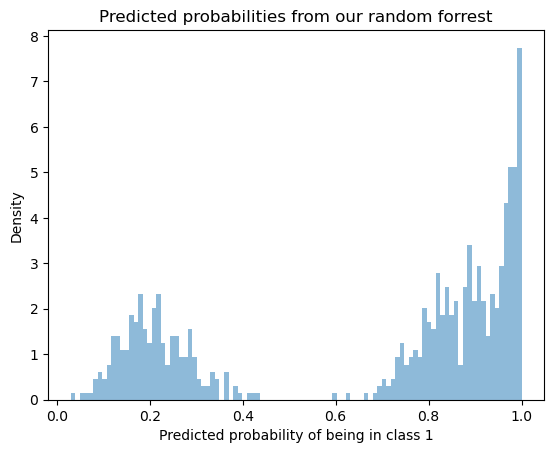

In [216]:
# Plot the predicted probabilities from the random forrest
hist_pred_prob(rf.predict_proba(TX_train_norm)[:,1], "random forrest")

NB: In random forrests, predicted probabilities are typically not well-calibrated. In fact, we see above that the distribution of predicted probabilities appears bimodal. If we wanted to improve calibration, we could recalibrate these predictions with [isotonic regression](https://scikit-learn.org/stable/modules/isotonic.html#isotonic) or [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression).

In [217]:
# Calibrate the random forest model with isotonic regression
calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv=5)
calibrated_rf.fit(TX_train_norm, Y_bin_train);

In [218]:
# Store the recalibrated RF model ready for predictions on new data
def final_rf(TX_data):
    TX_data_norm = (TX_data - TX_train_mean) / TX_train_std
    return calibrated_rf.predict_proba(TX_data_norm)[:,1]

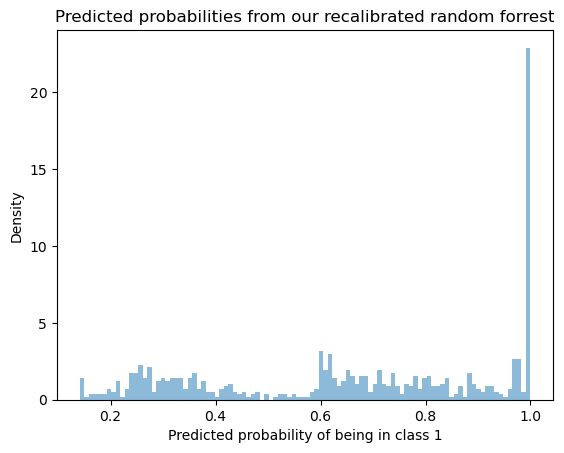

In [219]:
# Plot the predicted probabilities from the recalibrated random forrest
hist_pred_prob(final_rf(TX_train), "recalibrated random forrest")

### Neural network (Multi Layer Perceptron)

You may need to run the following commands to install the necessary libraries <br>
`!pip install tensorflow` <br>
`!pip install keras`

In [220]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

In [221]:
# Use the Sequential API to instantiate a fully connected architecture (ie, a multi-layer perceptron)
mlp = keras.Sequential([
    layers.Dense(10, activation="relu"), # 10 neurons in the first hidden layer, ReLU activation
    layers.Dense(10, activation="relu"), # 10 neurons in the second hidden layer, ReLU activation
    layers.Dense(1, activation="sigmoid") # 1 neuron in the output layer, output between 0 and 1
])

# Pepare the model for training by specifying the loss function, the optimizer and the metrics
mlp.compile(optimizer="rmsprop", # faster than stochastic gradient descent
              loss="binary_crossentropy", # loss function for binary classification
              metrics=["accuracy"]) # metric to monitor during training

In [222]:
# For fitting our mlp we will further split the training data into mlp_training and mlp_validation sets
mlp_TX_train_norm, mlp_TX_val, mlp_Y_bin_train, mlp_Y_bin_val = train_test_split(TX_train_norm,  Y_bin_train.reshape(-1,1), test_size=1/3, random_state=42)

# We interrupt training when accuracy on the validation set has stopped improving for two epochs
# (NB: This is a form of regularization called early stopping, which helps prevent overfitting)
Callback = EarlyStopping(monitor='val_accuracy', patience=2)

mlp.fit(mlp_TX_train_norm, mlp_Y_bin_train, epochs=5, batch_size=128, verbose=0, callbacks=[Callback],
    validation_data=(mlp_TX_val, mlp_Y_bin_val));

 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


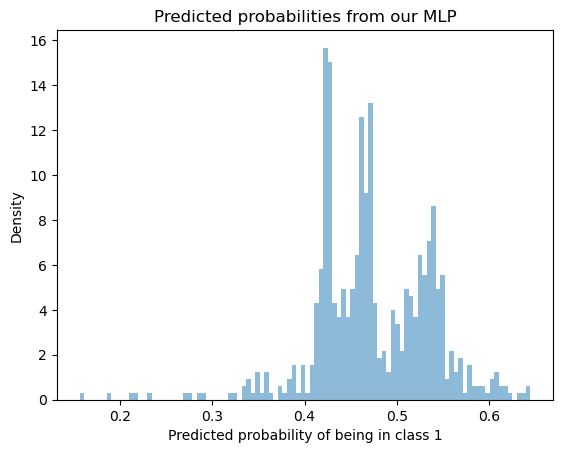

In [223]:
# Plot the predicted probabilities
hist_pred_prob(mlp.predict(TX_train_norm), "MLP")

We see that the distribution of the predicted probabilites from our MLP model do not appear bimodal (in contrast with ou RF model.) This does not mean that this will translate with better performance of our MLP compare to our RF model. To evaluate that, we will need to properly evaluate the performance of each model.

In [224]:
# Store a final MLP model ready for predictions on new data
def final_mlp(TX_data):
    TX_data_norm = (TX_data - TX_train_mean) / TX_train_std
    return mlp.predict(TX_data_norm, verbose=0)[:,0]

### Quick look at differences in predictions for the two models on the test data

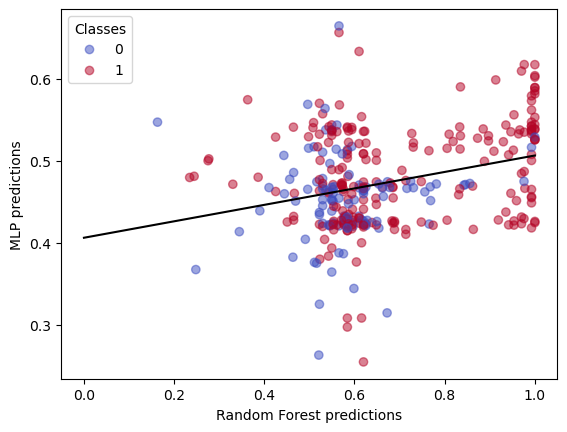

In [225]:
# create a scatter plot where color is blue if the true class is 0 and red if the true class is 1
scatter = plt.scatter(final_rf(TX_test), final_mlp(TX_test), c=Y_bin_test, cmap="coolwarm", alpha=0.5)

# add a legend for the colors
plt.legend(*scatter.legend_elements(), loc="upper left", title="Classes")

# add x and y axis labels
plt.xlabel("Random Forest predictions")
plt.ylabel("MLP predictions");

# fit a regression line to scatter plot
m, b = np.polyfit(final_rf(TX_test), final_mlp(TX_test), 1)

# add the regression line
plt.plot(np.array([0,1]), m*np.array([0,1]) + b, color='black');


Here we just confirm that the two models are different but their predictions are positively correlated. Note that this is *NOT* a proper evaluation/comparaison of the models' performance.

### Save data and models in a pickle file


In [226]:
import pickle

with open('data_and_models.pkl', 'wb') as f:
    pickle.dump({
        'TX_train': TX_train,
        'TX_test': TX_test,
        'Y_bin_train': Y_bin_train,
        'Y_bin_test': Y_bin_test,
        'TX_train_mean': TX_train_mean,
        'TX_train_std': TX_train_std,
        'rf': rf,
        'calibrated_rf': calibrated_rf,
        'mlp': mlp
    }, f)

## References
- *[An introduction to statistical learning: With applications in Python.](https://www.statlearning.com)* James, G., Witten, D., Hastie, T., Tibshirani, R. and Taylor, J., 2023. (Chapter 8: Tree-Based Methods p. 311.)
- *[Deep learning with Python](https://books.google.com/books?id=mjVKEAAAQBAJ&printsec=frontcover&source=gbs_ge_summary_r&cad=0#v=onepage&q&f=false)*. Chollet, F. 2021. (Chapter 7: Working with Keras: A deep dive p. 172.)